# Transforms and Resampling

This tutorial explains how to apply transforms to images.

In [1]:
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

## Creating and Manipulating Transforms

A number of different spatial transforms are available in SimpleITK.

The simplest is the Identity Transform.  This transform simply returns input points unaltered.

In [2]:
dimension = 2

print('*Identity Transform*')
identity = sitk.Transform(dimension, sitk.sitkIdentity)
print('Dimension: ' + str(identity.GetDimension()))

# Points are always defined in physical space
point = (1.0, 1.0)
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print('Point ' + str(point) + ' transformed is ' + str(transformed_point))

transform_point(identity, point)

*Identity Transform*
Dimension: 2
Point (1.0, 1.0) transformed is (1.0, 1.0)


The affine transform is capable of representing translations, rotations, shearing, and scaling. A number of other transforms exist to represent non-affine deformations, well-behaved rotation in 3D, etc. See the [Transforms](22_Transforms.ipynb) tutorial for more information.

## Applying Transforms to Images

Create a function to display the images that is aware of image spacing.

In [6]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda,
            extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower')
    
    if(title):
        plt.title(title)

Create a grid image.

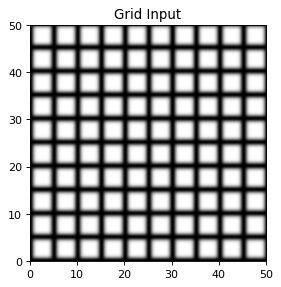

In [7]:
grid = sitk.GridSource(outputPixelType=sitk.sitkUInt16,
    size=(250, 250),
    sigma=(0.5, 0.5),
    gridSpacing=(5.0, 5.0),
    gridOffset=(0.0, 0.0),
    spacing=(0.2,0.2))
myshow(grid, 'Grid Input')

To apply the transform, a resampling operation is required.

Point (1.0, 1.0) transformed is (4.1, 5.6)


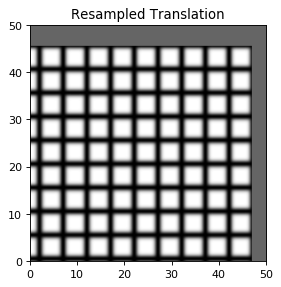

In [8]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

translation.SetOffset((3.1, 4.6))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, 'Resampled Translation')

What happened?  The translation is positive in both directions.  Why does the output image move down and to the left?  It important to keep in mind that a transform in a resampling operation defines *the transform from the output space to the input space*.

Point (1.0, 1.0) transformed is (-2.1, -3.5999999999999996)


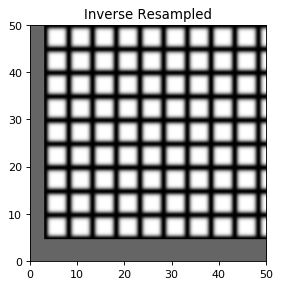

In [9]:
translation.SetOffset(-1*np.array(translation.GetParameters()))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, 'Inverse Resampled')

An affine (line preserving) transformation, can perform translation:

In [10]:
def affine_translate(transform, x_translation=3.1, y_translation=4.6):
    new_transform = sitk.AffineTransform(transform)
    new_transform.SetTranslation((x_translation, y_translation))
    resampled = resample(grid, new_transform)
    myshow(resampled, 'Translated')
    return new_transform
    
affine = sitk.AffineTransform(dimension)

interact(affine_translate, transform=fixed(affine), x_translation=(-5.0, 5.0), y_translation=(-5.0, 5.0))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTMuMSwgZGVzY3JpcHRpb249dSd4X3RyYW5zbGF0aW9uJywgbWF4PTUuMCwgbWluPS01LjApLCBGbG9hdFNsaWRlcih2YWzigKY=


<function __main__.affine_translate>

or scaling:

In [11]:
def affine_scale(transform, x_scale=3.0, y_scale=0.7):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,0] = x_scale
    matrix[1,1] = y_scale
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(grid, new_transform)
    myshow(resampled, 'Scaled')
    print(matrix)
    return new_transform

affine = sitk.AffineTransform(dimension)

interact(affine_scale, transform=fixed(affine), x_scale=(0.2, 5.0), y_scale=(0.2, 5.0))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTMuMCwgZGVzY3JpcHRpb249dSd4X3NjYWxlJywgbWF4PTUuMCwgbWluPTAuMiksIEZsb2F0U2xpZGVyKHZhbHVlPTAuNyzigKY=


<function __main__.affine_scale>

or rotation:

In [12]:
def affine_rotate(transform, degrees=15.0):
    parameters = np.array(transform.GetParameters())
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    radians = -np.pi * degrees / 180.
    rotation = np.array([[np.cos(radians), -np.sin(radians)],[np.sin(radians), np.cos(radians)]])
    new_matrix = np.dot(rotation, matrix)
    new_transform.SetMatrix(new_matrix.ravel())
    resampled = resample(grid, new_transform)
    print(new_matrix)
    myshow(resampled, 'Rotated')
    return new_transform
    
affine = sitk.AffineTransform(dimension)

interact(affine_rotate, transform=fixed(affine), degrees=(-90.0, 90.0))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTE1LjAsIGRlc2NyaXB0aW9uPXUnZGVncmVlcycsIG1heD05MC4wLCBtaW49LTkwLjApLCBPdXRwdXQoKSksIF9kb21fY2zigKY=


<function __main__.affine_rotate>

or shearing:

In [13]:
def affine_shear(transform, x_shear=0.3, y_shear=0.1):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,1] = -x_shear
    matrix[1,0] = -y_shear
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(grid, new_transform)
    myshow(resampled, 'Sheared')
    print(matrix)
    return new_transform

affine = sitk.AffineTransform(dimension)

interact(affine_shear, transform=fixed(affine), x_shear=(0.1, 2.0), y_shear=(0.1, 2.0))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMywgZGVzY3JpcHRpb249dSd4X3NoZWFyJywgbWF4PTIuMCwgbWluPTAuMSksIEZsb2F0U2xpZGVyKHZhbHVlPTAuMSzigKY=


<function __main__.affine_shear>